# Network Modeling with SEIRS+ Notebook 

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from seirsplus.models import *
from network_utils import *
from stats_utils import *
from intervention_utils import *
from camp_networks import *
import pickle as pkl

In [9]:
# Total number of people 
n_pop = 18700

# Sample the population age, and parameter rates
sample_pop = sample_population(n_pop, "data/augmented_population.csv")

### 1) Load base graph for Moria

In [14]:
with open("Moria_graph.pkl", "rb") as f:
    graph = pkl.load(f)

In [15]:
graph

### 2) Plot the basic network degrees

In [16]:
min_G, max_G = min_degree(graph), max_degree(graph)
min_G, max_G

(0, 199)

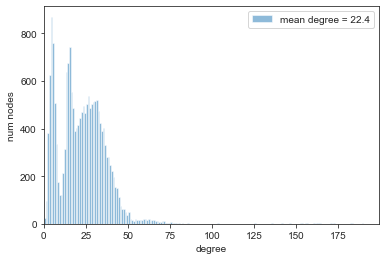

In [17]:
plot_degree_distn(graph, max_degree=max_G)

### 3) Create node groups of 10 year age bucket to track the results

In [18]:
node_groups=create_node_groups(graph)

### 4) Define model parameters

In [55]:
household_weight = 0.98  # Edge weight for connections within each structure
neighbor_weight = 0.017
food_weight = 0.407 # Edge weight for connections in the food queue 

transmission_rate = 1.28
progression_rate = round(1/5.1, 3)
recovery_rate = 0.056 # Approx 1/18 -> Recovery occurs after 18 days
hosp_rate = round(1/11.4, 3) #1/6.3 # From Tucker Model
# crit_rate = 0.3 # From camp_params
crit_rate = list((sample_pop["death_rate"] / sample_pop["prob_symptomatic"]) / sample_pop["prob_hospitalisation"])
death_rate = 0.75


prob_global_contact = 1
prob_detected_global_contact = 1

# prob_hosp_to_critical = list(sample_pop["death_rate"]/sample_pop["prob_hospitalisation"])
prob_death = list(sample_pop["death_rate"])
prob_asymptomatic = list(1 - sample_pop["prob_symptomatic"])
prob_symp_to_hosp = list(sample_pop["prob_hospitalisation"])

init_symp_cases = 1
init_asymp_cases = 0

### 5) Running the base model

In [35]:
# Model construction
ref_model = SymptomaticSEIRSNetworkModel(G=graph, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, 
                                         lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, p=prob_global_contact, a=prob_asymptomatic, f=0.75, 
                                         h=prob_symp_to_hosp, q=prob_detected_global_contact, initI_S=init_symp_cases, initI_A=init_asymp_cases, store_Xseries=True)

In [36]:
t_steps = 200
node_states, simulation_results = run_simulation(ref_model, t_steps)

  0%|          | 0/200 [00:00<?, ?it/s]

Running simulation for 200 steps...



100%|██████████| 200/200 [19:38<00:00,  5.89s/it] 


In [60]:
# Model name for storage
fig_name = f"BaseSymptomaticModel_Houseweight={household_weight}_NeighWeight={neighbor_weight}_FoodWeight={food_weight}_ + \
TransRate={transmission_rate}_RecRate={recovery_rate}_ProgRate={progression_rate}_HospRate={hosp_rate}_CritRate={sum(crit_rate)/len(crit_rate)}_DeathRate={death_rate}_initI_S={init_symp_cases}_initI_A={init_asymp_cases}_Tsteps={t_steps}"

In [61]:
#here we set up a parallel computing to run experiments in parallel and aggregate the results

In [62]:
output_df = results_to_df(simulation_results, store=True, store_name=f"results/{fig_name}.csv")

In [64]:
output_df

,Susceptible,Exposed,Infected_Presymptomatic,Infected_Symptomatic,Infected_Asymptomatic,Hospitalized,Recovered,Fatalities,Detected_Presymptomatic,Detected_Symptomatic,Detected_Asymptomatic,T_index,Time
0,18697.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1
1,18696.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,2
2,18694.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7,3
3,18691.0,7.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11,4
4,18690.0,8.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0,18052.0,648.0,0.0,0.0,0.0,75480,196
196,0.0,0.0,0.0,0.0,0.0,0.0,18052.0,648.0,0.0,0.0,0.0,75480,197
197,0.0,0.0,0.0,0.0,0.0,0.0,18052.0,648.0,0.0,0.0,0.0,75480,198
198,0.0,0.0,0.0,0.0,0.0,0.0,18052.0,648.0,0.0,0.0,0.0,75480,199


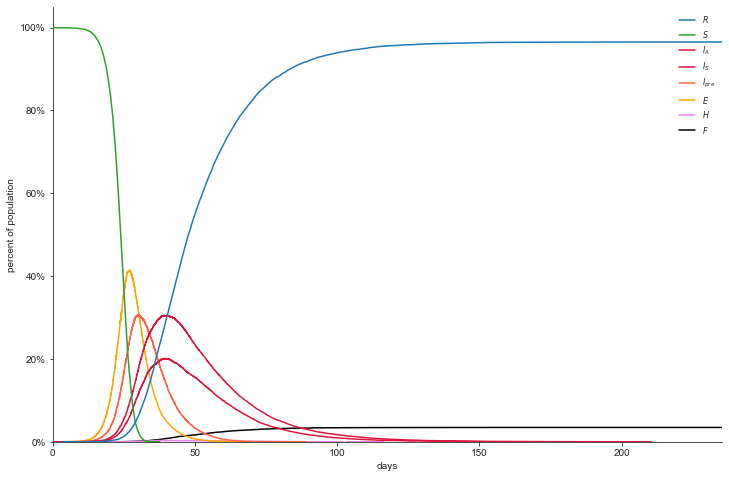

In [65]:
fig, ax = ref_model.figure_basic()#vlines=interventions.get_checkpoints()['t'])
fig.savefig(f"plots/{fig_name}_figBasic.png")

### 6) Define Interventions

With the interventions module, we can create an intervention with just a time step and a custom network referring to that intervention, as well as remove/edit them from the list. The method get_checkpoints() will allow us to get the dictionary to be fed to the SEIRS+ model

#### 6.1) First, define the intervention graphs

In [66]:
# This is social distancing within the food queue 
distancing_graph = create_distancing_graph(graph, scale=10, min_num_edges=4)

# This also includes neighbor/friendship edges
quarantine_graph = create_quarantine_graph(graph, scale=2, min_num_edges=2)

Min degree: 0 Max degree: 192


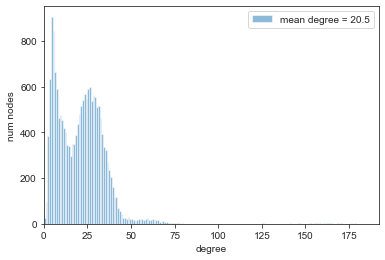

In [67]:
min_D, max_D = min_degree(distancing_graph), max_degree(distancing_graph)
print("Min degree:", min_D, "Max degree:", max_D)

# As we can see, there isn't much of a difference when we only cut food-queue interactions, 
# which means we need a harder distancing policy
plot_degree_distn(distancing_graph, max_degree=max_D)

Min degree: 0 Max degree: 18


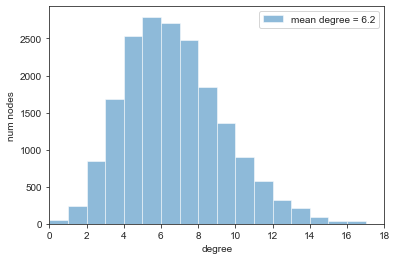

In [68]:
min_Q, max_Q = min_degree(quarantine_graph), max_degree(quarantine_graph)
print("Min degree:", min_Q, "Max degree:", max_Q)

plot_degree_distn(quarantine_graph, max_degree=max_Q)

#### 6.2) Construct the checkpoints

In [69]:
interventions = Interventions()

# Simulate quarantine (no masks, but could be added!)
interventions.add(quarantine_graph, 3, beta=transmission_rate)

# Simulate HALT of quarantine and start wearing masks
reduction_percentage = 0.5
interventions.add(graph, 63, beta=transmission_rate*reduction_percentage)

# Simulate HALT of wearing masks
interventions.add(graph, 93, beta=transmission_rate)

checkpoints = dict(interventions.checkpoints)

### 7) Running the model with interventions

In [76]:
# Model construction
interventions_model = SymptomaticSEIRSNetworkModel(G=graph, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, 
                                         lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, p=prob_global_contact, a=prob_asymptomatic, f=0.75, 
                                         h=prob_symp_to_hosp, q=prob_detected_global_contact, initI_S=init_symp_cases, initI_A=init_asymp_cases, store_Xseries=True)

In [77]:
t_steps = 200
node_states, simulation_results = run_simulation(interventions_model, t_steps, checkpoints)



  0%|          | 0/200 [00:00<?, ?it/s]

Running simulation for 200 steps...





  1%|          | 2/200 [00:00<01:23,  2.38it/s]

  2%|▏         | 3/200 [00:03<03:11,  1.03it/s]

  2%|▏         | 4/200 [00:04<03:08,  1.04it/s]

  2%|▎         | 5/200 [00:04<03:05,  1.05it/s]

  3%|▎         | 6/200 [00:06<03:09,  1.02it/s]

  4%|▎         | 7/200 [00:07<03:20,  1.04s/it]

  4%|▍         | 8/200 [00:08<03:26,  1.08s/it]

  4%|▍         | 9/200 [00:09<03:45,  1.18s/it]

  5%|▌         | 10/200 [00:11<04:02,  1.27s/it]

  6%|▌         | 11/200 [00:13<04:26,  1.41s/it]

  6%|▌         | 12/200 [00:15<05:17,  1.69s/it]

  6%|▋         | 13/200 [00:18<06:34,  2.11s/it]

  7%|▋         | 14/200 [00:22<08:35,  2.77s/it]

  8%|▊         | 15/200 [00:28<11:04,  3.59s/it]

  8%|▊         | 16/200 [00:35<14:34,  4.75s/it]

  8%|▊         | 17/200 [00:49<22:58,  7.53s/it]

  9%|▉         | 18/200 [01:08<33:12, 10.95s/it]

 10%|▉         | 19/200 [01:30<42:39, 14.14s/it]

 10%|█         | 20/200 [01:59<55:54, 18.63s/it]

 10%|█         | 21/200 [02:33<1:09:48, 23.40s/it]

 11%

In [90]:
# Model name for storage - adjust accordingly to interventions
mean_degree = round(sum([degree for node, degree in quarantine_graph.degree])/len(quarantine_graph.degree), 3) # Get the mean degree
quarantine_duration = "3-63"
fig_name = f"InterventionsModel_Hweight={household_weight}_NWeight={neighbor_weight}_FWeight={food_weight}_ + \
TransRate={transmission_rate}_RecRate={recovery_rate}_ProgRate={progression_rate}_HospRate={hosp_rate}_CritRate={sum(crit_rate)/len(crit_rate)}_ + \
DeathRate={death_rate}_initI_S={init_symp_cases}_initI_A={init_asymp_cases}_Tsteps={t_steps}_QDegree={mean_degree}_QDuration={quarantine_duration}"

In [91]:
#here we set up a parallel computing to run experiments in parallel and aggregate the results

In [92]:
output_df = results_to_df(simulation_results, store=True, store_name=f"results/{fig_name}.csv")

In [93]:
output_df

,Susceptible,Exposed,Infected_Presymptomatic,Infected_Symptomatic,Infected_Asymptomatic,Hospitalized,Recovered,Fatalities,Detected_Presymptomatic,Detected_Symptomatic,Detected_Asymptomatic,T_index,Time
0,18697.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1
1,18695.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2
2,18693.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,3
3,18690.0,5.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,4
4,18684.0,11.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0,18102.0,598.0,0.0,0.0,0.0,75430,196
196,0.0,0.0,0.0,0.0,0.0,0.0,18102.0,598.0,0.0,0.0,0.0,75430,197
197,0.0,0.0,0.0,0.0,0.0,0.0,18102.0,598.0,0.0,0.0,0.0,75430,198
198,0.0,0.0,0.0,0.0,0.0,0.0,18102.0,598.0,0.0,0.0,0.0,75430,199


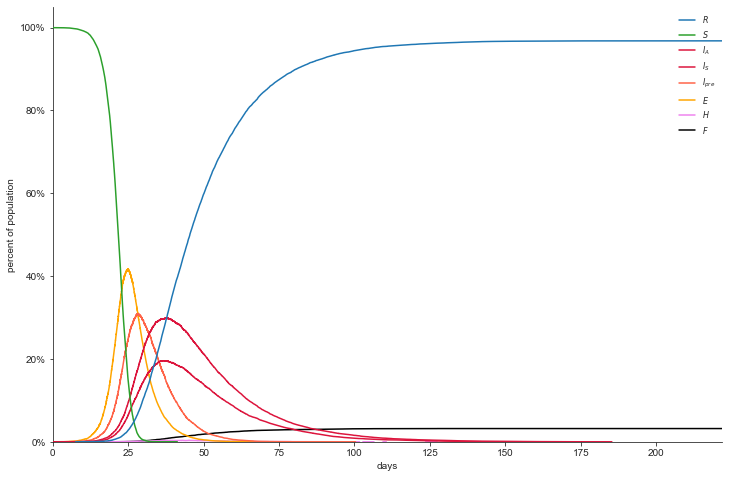

In [94]:
fig, ax = interventions_model.figure_basic()#vlines=interventions.get_checkpoints()['t'])
fig.savefig(f"plots/{fig_name}_figBasic.png")